# 介绍非参数池化注意力

- 具体数值例子；
- 生成数据集测试；

In [17]:
import torch
from torch.nn import functional as F

import numpy as np
from matplotlib import pyplot as plt


from lib.d2l_torch import DataModule, plot, show_heatmaps

## 具体数值例子

现在假设有：
- `query` 为 `{1,5,10}`，有三个值需要被查询；
- `key-value` 对为，`{(5, 50), (15, 100)}`，及有两个 `key-value` 对；

计算步骤如下：

1. 计算 query 与 key 之间的差（会得到一个 3*2 的矩阵）
2. 计算 attention weight
3. 将 attention weight 与对应的 value 相乘，得到最终结果；

In [9]:
query_t = np.array([1, 5, 10]) # query
key_t = np.array([5, 15]) # keys
value_t = np.array([50, 100]) # value

In [20]:
# 1. 首先计算 query 和 key 之间的差
query_key_diffs = query_t.reshape((-1, 1)) - key_t.reshape((1, -1)) # 一个 query 会和所有 keys 进行相减
query_key_diffs = torch.from_numpy(query_key_diffs)
print(query_key_diffs)

tensor([[ -4, -14],
        [  0, -10],
        [  5,  -5]])


In [21]:
# 2. 接着计算 softmax, 对于每一个 query, 求和为 0
attention_weights = F.softmax(- query_key_diffs**2 / 2,  dim=1) # 权重和 value 相乘
print(attention_weights)

tensor([[1.0000e+00, 8.1940e-40],
        [1.0000e+00, 1.9287e-22],
        [5.0000e-01, 5.0000e-01]])


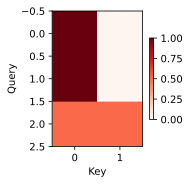

In [22]:
# 绘制 attention map 的图像
show_heatmaps(
    [[attention_weights]],
    xlabel='Key',
    ylabel='Query'
)

In [12]:
# 3. 最后使用 softmax 与 value 相乘
value_t = torch.from_numpy(value_t).float()
query_value_t = torch.matmul(attention_weights, value_t.reshape(-1,1))
print(query_value_t)

tensor([[50.],
        [50.],
        [75.]])


## 生成数据集测试

In [15]:
def plot_kernel_reg(data, y_hat):
    """绘制图像, 将原始数据集和预测的绘制在一起

    Args:
        y_hat (_type_): 预测得到的 y 值
    """
    plot(
        data.x_val, 
        [data.y_val, y_hat.detach().numpy()], 'x', 'y', legend=['Truth', 'Pred'],
        xlim=[0, 5], ylim=[-1, 5]
    )
    plt.plot(data.x_train, data.y_train, 'o', alpha=0.5)

In [13]:
class NonlinearData(DataModule):
    """生成数据集,
     y = 2*sin(x) + x^0.8 + epsilon
    """
    def __init__(self, n, batch_size):
        self.save_hyperparameters()
        f = lambda x: 2 * torch.sin(x) + x**0.8
        self.x_train, _ = torch.sort(torch.rand(n) * 5)
        self.y_train = f(self.x_train) + torch.randn(n) # 用于训练的 label
        self.x_val = torch.arange(0, 5, 5.0/n)
        self.y_val = f(self.x_val) # 用于测试的 label

    def get_dataloader(self, train):
        arrays = (self.x_train, self.y_train) if train else (self.x_val, self.y_val)
        return self.get_tensorloader(arrays, train)

In [14]:

# #############
# 非参数的注意力汇聚
# #############
def diff(queries, keys):
    """计算 query 和 key 的距离
    """
    return queries.reshape((-1, 1)) - keys.reshape((1, -1))

def attention_pool(query_key_diffs, values):
    attention_weights = F.softmax(- query_key_diffs**2 / 2, dim=1) # 计算权重
    return torch.matmul(attention_weights, values), attention_weights # 权重和 value 相乘

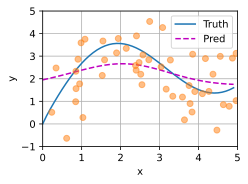

In [16]:
n = 50
data = NonlinearData(n, batch_size=10)

# 使用平均值
y_hat = data.y_train.mean().repeat(n)
# 非参数注意力
y_hat, attention_weights = attention_pool(
    query_key_diffs = diff(data.x_val, data.x_train), 
    values = data.y_train
)

plot_kernel_reg(data, y_hat)

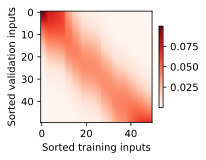

In [19]:
show_heatmaps(
    [[attention_weights]],
         xlabel='Sorted training inputs',
        ylabel='Sorted validation inputs'
)